The current dataset presents monthly labor statistics for all the provinces of Canada in 01.1976-01.2023. It is available here https://www.kaggle.com/datasets/pienik/unemployment-in-canada-by-province-1976-present?resource=download

In [1]:
# First, let's load the data and take a look at it 

import numpy as np
import pandas as pd

df = pd.read_csv('Unemployment_Canada_1976_present.csv')
df.head()

,REF_DATE,GEO,Sex,Age group,Employment,Full-time employment,Labour force,Part-time employment,Population,Unemployment,Employment rate,Participation rate,Unemployment rate
0,1976-01,Alberta,Both sexes,15 to 24 years,231800.0,174900.0,252300.0,56900.0,362300.0,20500.0,64.0,69.6,8.1
1,1976-01,Alberta,Both sexes,15 to 64 years,802400.0,682100.0,837500.0,120300.0,1154800.0,35000.0,69.5,72.5,4.2
2,1976-01,Alberta,Both sexes,15 years and over,819500.0,693700.0,856500.0,125800.0,1276700.0,37000.0,64.2,67.1,4.3
3,1976-01,Alberta,Both sexes,25 to 54 years,491400.0,439800.0,505800.0,51600.0,661700.0,14400.0,74.3,76.4,2.8
4,1976-01,Alberta,Both sexes,25 years and over,587700.0,518800.0,604200.0,68900.0,914400.0,16500.0,64.3,66.1,2.7


In [2]:
# first, let's take a look at Basic Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38985 entries, 0 to 38984
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   REF_DATE               38985 non-null  object 
 1   GEO                    38985 non-null  object 
 2   Sex                    38985 non-null  object 
 3   Age group              38985 non-null  object 
 4   Employment             38985 non-null  float64
 5   Full-time employment   37290 non-null  float64
 6   Labour force           38985 non-null  float64
 7   Part-time employment   37289 non-null  float64
 8   Population             38985 non-null  float64
 9   Unemployment           38979 non-null  float64
 10  Employment rate        38985 non-null  float64
 11  Participation rate     38985 non-null  float64
 12  Unemployment rate      38979 non-null  float64
dtypes: float64(9), object(4)
memory usage: 3.9+ MB


In [3]:
# Time should be changed to the time datetime type for the convenience; 
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])

# Let's loop through specific categorical columns to see what unique values they got
categorical_columns = ['GEO', 'Sex', 'Age group']
for column in categorical_columns:
    print(f'Unique values in "{column}":\n{df[column].unique()}\n')
    
# also, let's check for duplicate rows
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

# check for missing values count for each column
missing_values = df.isnull().sum()
print(f'Missing values for each row:\n{missing_values}')

Unique values in "GEO":
['Alberta' 'British Columbia' 'Canada' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan']

Unique values in "Sex":
['Both sexes']

Unique values in "Age group":
['15 to 24 years' '15 to 64 years' '15 years and over' '25 to 54 years'
 '25 years and over' '55 years and over' '15 to 19 years' '20 to 24 years'
 '55 to 64 years']

Number of duplicate rows: 0
Missing values for each row:
REF_DATE                    0
GEO                         0
Sex                         0
Age group                   0
Employment                  0
Full-time employment     1695
Labour force                0
Part-time employment     1696
Population                  0
Unemployment                6
Employment rate             0
Participation rate          0
Unemployment rate           6
dtype: int64


In [4]:
# For full and part-time employment, let's see the counts of missing values for each province
print("Missing values for Full-time employment by province:")
print(df[df['Full-time employment'].isnull()]['GEO'].value_counts())
print("\nMissing values for Part-time employment by province:")
print(df[df['Part-time employment '].isnull()]['GEO'].value_counts())

# Now, since there are only 6 missing rows for unemployment rates, let's print those rows
print("\nRows with missing Unemployment rates:")
missing_unemployment_rates = df[df['Unemployment rate'].isnull()]
print(missing_unemployment_rates)

# Let's also identify the latest date for missing data to understand if it's within the scope of our interest
# Identify rows with any missing values
missing_data_rows = df[df.isnull().any(axis=1)]
# Find the latest date among these rows
latest_missing_date = missing_data_rows['REF_DATE'].max()
print(f'The latest date with any missing entry is: {latest_missing_date}')


Missing values for Full-time employment by province:
GEO
Canada    1695
Name: count, dtype: int64

Missing values for Part-time employment by province:
GEO
Canada                       1695
Newfoundland and Labrador       1
Name: count, dtype: int64

Rows with missing Unemployment rates:
       REF_DATE                   GEO         Sex          Age group  \
206  1976-03-01          Saskatchewan  Both sexes  55 years and over   
344  1976-05-01          Saskatchewan  Both sexes  55 years and over   
695  1976-11-01               Alberta  Both sexes  55 years and over   
3317 1980-01-01               Alberta  Both sexes  55 years and over   
3920 1980-09-01  Prince Edward Island  Both sexes  55 years and over   
3989 1980-10-01  Prince Edward Island  Both sexes  55 years and over   

      Employment  Full-time employment  Labour force  Part-time employment   \
206      57800.0               48900.0       58100.0                 9000.0   
344      61600.0               49700.0       620

Given the insights from the dataset, we'll proceed to impute missing values for full and part-time employment for Canada by summing up values from all other provinces for the same date as those are available. Additionally, we'll impute missing values for unemployment and unemployment rate using the labor force and employment data which is available for those days. Let's break down the steps and add guiding comments for clarity.
Impute Missing Values for Full and Part-Time Employment

In [5]:
# Impute missing 'Full-time employment' and 'Part-time employment' for Canada
# First loop: Impute missing 'Full-time employment' for Canada by summing values from other provinces
for index, row in df[df['Full-time employment'].isnull()].iterrows():
    # Identify the date and age group for the missing value
    date = row['REF_DATE']
    age_group = row['Age group']
    
    # Sum values for each province except for Canada and within the same 'Age group', and impute the missing values for Canada
    full_time_sum = df[(df['REF_DATE'] == date) & (df['GEO'] != 'Canada') & (df['Age group'] == age_group)]['Full-time employment'].sum()
    df.at[index, 'Full-time employment'] = full_time_sum
    
# Second loop: calculate 'Part-time employment' as 'Employment' minus 'Full-time employment' where missing
for index, row in df[df['Part-time employment '].isnull()].iterrows():
    # Calculate part-time employment as total employment minus full-time employment
    df.at[index, 'Part-time employment '] = row['Employment'] - row['Full-time employment']

# Impute missing 'Unemployment' and 'Unemployment rate'
df['Unemployment'] = df.apply(lambda x: x['Labour force'] - x['Employment'] if pd.isnull(x['Unemployment']) else x['Unemployment'], axis=1)
df['Unemployment rate'] = df.apply(lambda x: round((x['Unemployment'] / x['Labour force']) * 100, 1) if pd.isnull(x['Unemployment rate']) else x['Unemployment rate'], axis=1)

# Verify no more missing values for 
print(df.isnull().sum())


REF_DATE                 0
GEO                      0
Sex                      0
Age group                0
Employment               0
Full-time employment     0
Labour force             0
Part-time employment     0
Population               0
Unemployment             0
Employment rate          0
Participation rate       0
Unemployment rate        0
dtype: int64


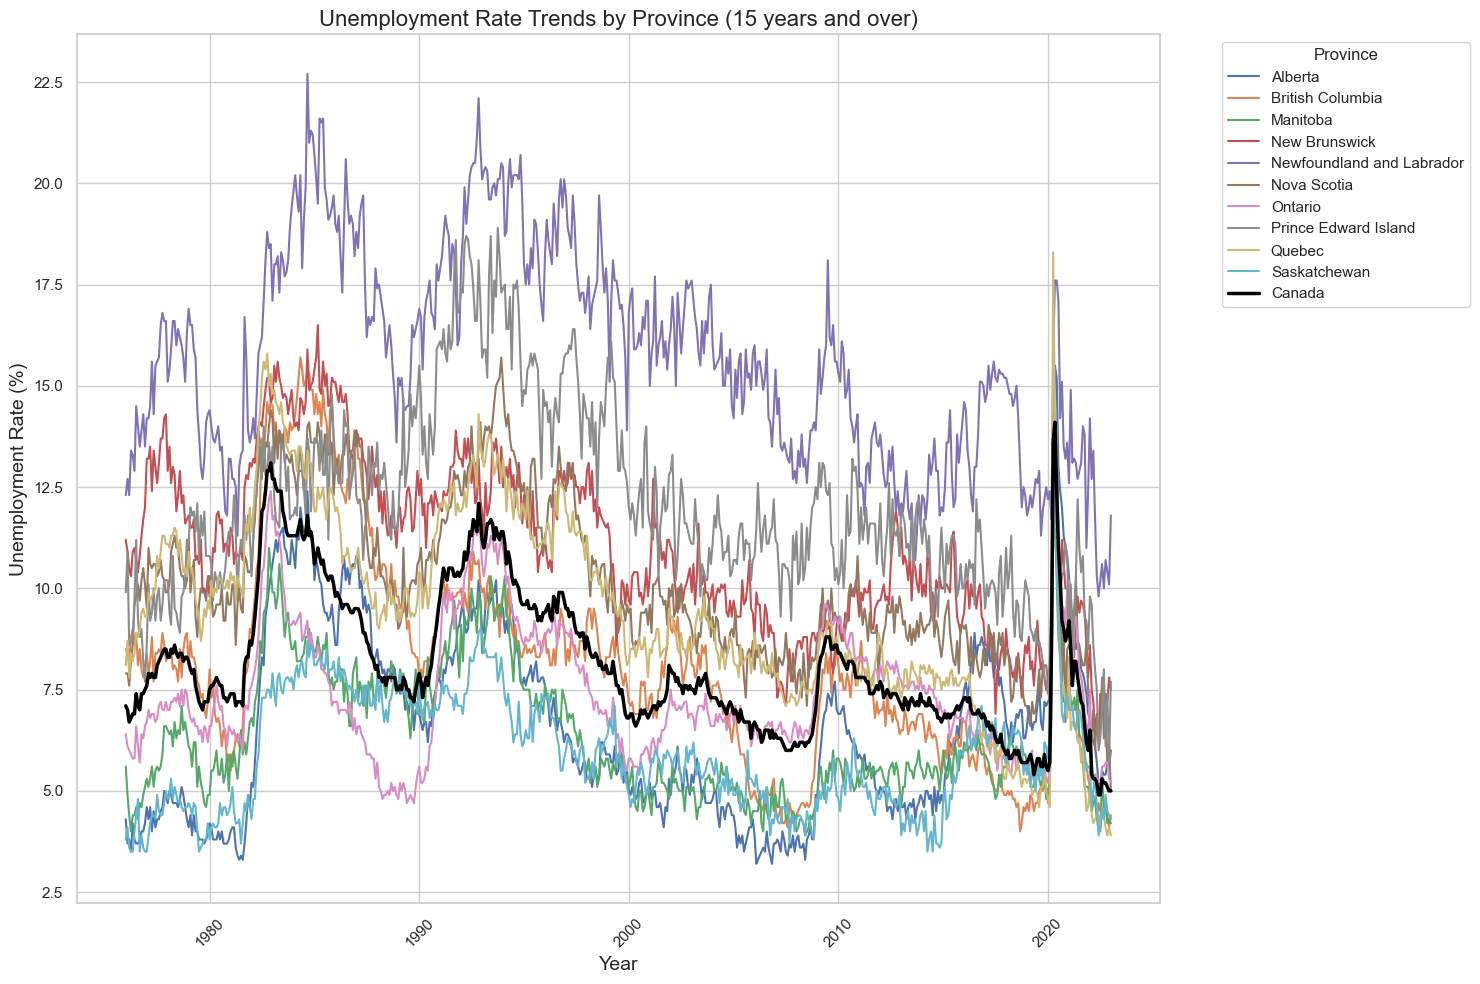

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Filter data for '15 years and over'
df_filtered = df[df['Age group'] == '15 years and over']

plt.figure(figsize=(15, 10))

# Plot for all provinces except Canada
sns.lineplot(data=df_filtered[df_filtered['GEO'] != 'Canada'], x='REF_DATE', y='Unemployment rate', hue='GEO', linewidth=1.5)

# Plot for Canada with a thicker line
sns.lineplot(data=df_filtered[df_filtered['GEO'] == 'Canada'], x='REF_DATE', y='Unemployment rate', color='black', label='Canada', linewidth=2.5)

plt.title('Unemployment Rate Trends by Province (15 years and over)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
# Adjust the legend to handle the 'Canada' label properly
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# Export the filtered DataFrame used for the visualization to a CSV file for Flourish
# Pivot the table to have GEO as columns and Unemployment Rate as values
df_pivoted = df_filtered[['REF_DATE', 'GEO', 'Unemployment rate']].pivot(index='REF_DATE', columns='GEO', values='Unemployment rate')

# Reset the index to turn REF_DATE back into a column
df_pivoted.reset_index(inplace=True)

# Export the pivoted DataFrame to CSV for future use
df_pivoted.to_csv('Canada_unemployment_rate_trends.csv', index=False)

While it's not true for every province, for Canada in General the beginning of 2020 marked the global (i.e. since 1976) unemployment peak. As such, it makes sense to study in detail the period between 01.2018 and 01.2023 

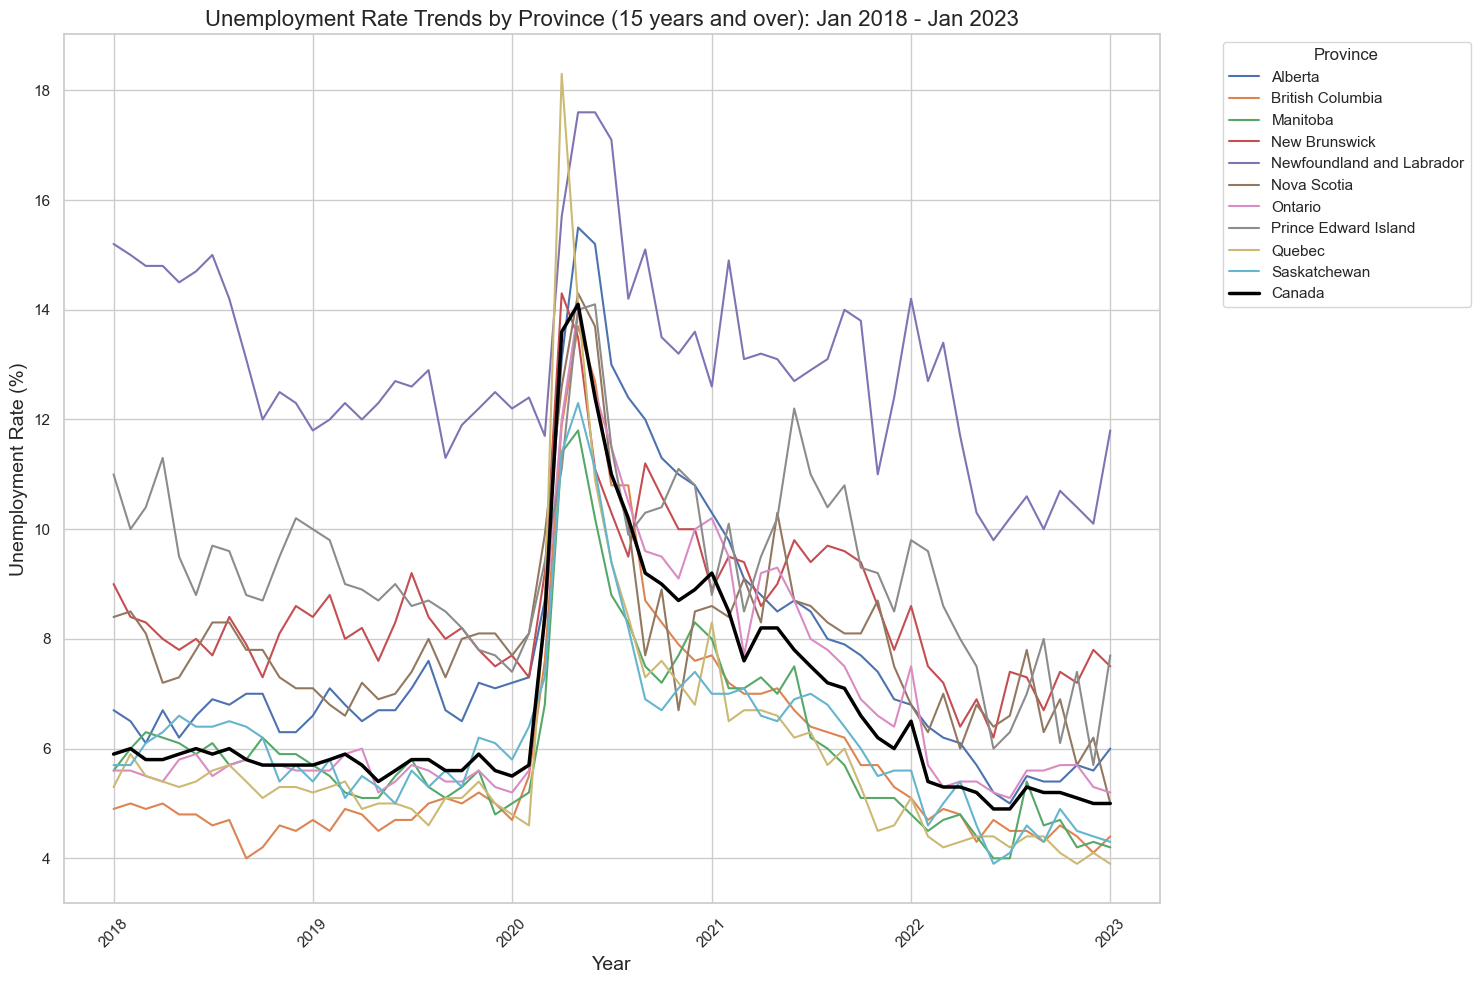

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plots
sns.set(style="whitegrid")

# Filter data for '15 years and over' and the specified date range
start_date = '2018-01-01'
end_date = '2023-01-01'
df_filtered = df[(df['Age group'] == '15 years and over') & (df['REF_DATE'] >= start_date) & (df['REF_DATE'] <= end_date)]

plt.figure(figsize=(15, 10))

# Plot for all provinces except Canada
sns.lineplot(data=df_filtered[df_filtered['GEO'] != 'Canada'], x='REF_DATE', y='Unemployment rate', hue='GEO', linewidth=1.5)

# Plot for Canada with a thicker line
sns.lineplot(data=df_filtered[df_filtered['GEO'] == 'Canada'], x='REF_DATE', y='Unemployment rate', color='black', label='Canada', linewidth=2.5)

plt.title('Unemployment Rate Trends by Province (15 years and over): Jan 2018 - Jan 2023', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Unemployment Rate (%)', fontsize=14)
plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export the filtered DF used for the visualization to a CSV file
df_filtered.to_csv('Canada_COVID_unemployment_rate_trends.csv', index=False)

# Pivot the table to have GEO as columns and Unemployment Rate as values
df_pivoted = df_filtered[['REF_DATE', 'GEO', 'Unemployment rate']].pivot(index='REF_DATE', columns='GEO', values='Unemployment rate')

# Reset the index to turn REF_DATE back into a column
df_pivoted.reset_index(inplace=True)

# Export the pivoted DataFrame to CSV for future use
df_pivoted.to_csv('Canada_unemployment_rate_trends.csv', index=False)

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

warnings.simplefilter(action='ignore', category=UserWarning)

# Define metrics to compare
metrics = ['Full-time employment', 'Part-time employment ', 'Unemployment rate']

# Define the time periods
pre_covid_period = (df['REF_DATE'] >= '2018-01-01') & (df['REF_DATE'] <= '2019-12-01')
covid_period = (df['REF_DATE'] >= '2020-01-01') & (df['REF_DATE'] <= '2021-12-01')

# Define age groups to analyze
age_groups = ['15 to 24 years', '25 to 54 years', '55 years and over']

# List of provinces for iteration
provinces = df['GEO'].unique()

# Adjusted list to store results
results = []

for province in provinces:
    for age_group in age_groups:
        for metric in metrics:
            # Filter the dataset for each province, age group, and the specified periods
            pre_covid_data = df[pre_covid_period & (df['GEO'] == province) & (df['Age group'] == age_group)][metric]
            covid_data = df[covid_period & (df['GEO'] == province) & (df['Age group'] == age_group)][metric]

            # Ensure equal lengths for Wilcoxon test
            min_length = min(len(pre_covid_data), len(covid_data))
            pre_covid_data = pre_covid_data.iloc[:min_length]
            covid_data = covid_data.iloc[:min_length]

            # Conduct the paired t-test
            # stat, p_value = ttest_rel(pre_covid_data, post_covid_data)
            # Conduct the Wilcoxon signed-rank test
            stat, p_value = wilcoxon(pre_covid_data, covid_data)

            # Calculate and round mean values
            pre_mean = round(np.mean(pre_covid_data), 1)
            covid_mean = round(np.mean(covid_data), 1)

            # Determine change direction
            if p_value < 0.05:
                change_direction = "increased" if covid_mean > pre_mean else "decreased"
            else:
                change_direction = "same"
            
            # Append results
            results.append({
                'Province': province,
                'Age Group': age_group,
                'Metric': metric,
                'Pre-COVID Mean': pre_mean,
                'COVID Mean': covid_mean,
                'Change': change_direction
            })

# Convert results to DataFrame for better visualization
# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)
results_df = pd.DataFrame(results)

# Initialize an adjusted list to store results, including percentages
adjusted_results = []

for result in results:
    # Extract necessary details for calculating percentages
    province = result['Province']
    age_group = result['Age Group']
    metric = result['Metric']
    
    # Only proceed if we're dealing with employment metrics
    if metric in ['Full-time employment', 'Part-time employment ']:
        pre_covid_data_labour = df[pre_covid_period & (df['GEO'] == province) & (df['Age group'] == age_group)]['Labour force']
        covid_data_labour = df[covid_period & (df['GEO'] == province) & (df['Age group'] == age_group)]['Labour force']
        
        # Ensure equal lengths for calculations
        min_length_pre = len(pre_covid_data_labour) # min(len(pre_covid_data_labour), len(result['Pre-COVID Mean']))
        min_length_post = len(covid_data_labour) # min(len(post_covid_data_labour), len(result['Post-COVID Mean']))
        
        # Calculate percentages
        pre_percentage = round((result['Pre-COVID Mean'] / pre_covid_data_labour.iloc[:min_length_pre].mean()) * 100, 1)
        covid_percentage = round((result['COVID Mean'] / covid_data_labour.iloc[:min_length_post].mean()) * 100, 1)
        
        # Adjust the result dictionary to include percentages
        result['Pre-COVID %'] = pre_percentage
        result['COVID %'] = covid_percentage
        # Only proceed if we're dealing with employment metrics
    if metric=='Unemployment rate':
        result['Pre-COVID %'] = result['Pre-COVID Mean']
        result['COVID %'] = result['COVID Mean']
        
    adjusted_results.append(result)

# Convert adjusted results to DataFrame for better visualization
adjusted_results_df = pd.DataFrame(adjusted_results)

# Display the DataFrame including percentage changes
adjusted_results_df

,Province,Age Group,Metric,Pre-COVID Mean,COVID Mean,Change,Pre-COVID %,COVID %
0,Alberta,15 to 24 years,Full-time employment,174070.8,142441.7,decreased,51.1,43.7
1,Alberta,15 to 24 years,Part-time employment,125891.7,120916.7,same,36.9,37.1
2,Alberta,15 to 24 years,Unemployment rate,12.0,19.4,increased,12.0,19.4
3,Alberta,25 to 54 years,Full-time employment,1353825.0,1311512.5,decreased,82.9,80.4
4,Alberta,25 to 54 years,Part-time employment,187212.5,187404.2,same,11.5,11.5
5,Alberta,25 to 54 years,Unemployment rate,5.6,8.2,increased,5.6,8.2
6,Alberta,55 years and over,Full-time employment,350783.3,343387.5,decreased,72.3,70.5
7,Alberta,55 years and over,Part-time employment,101558.3,96800.0,decreased,20.9,19.9
8,Alberta,55 years and over,Unemployment rate,6.8,9.7,increased,6.8,9.7
9,British Columbia,15 to 24 years,Full-time employment,190179.2,163100.0,decreased,47.7,42.4


In [10]:
# Pivot the DataFrame to have 'Province' and 'Age Group' as columns
pivot_df = adjusted_results_df.pivot_table(index='Metric', 
                                   columns=['Province', 'Age Group'], 
                                   values=['Pre-COVID %', 'COVID %'])

# Flatten the columns using a list comprehension
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index if you want 'Metric' as a column
pivot_df.reset_index(inplace=True)

# Save the pivoted DataFrame as a CSV file
pivot_df.to_csv('pivoted_percentage.csv', index=False)


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# Define metrics to compare
metrics = ['Full-time employment', 'Labour force', 'Part-time employment ', 'Population', 'Unemployment rate']

# Define the time periods
pre_covid_period = (df['REF_DATE'] >= '2019-01-01') & (df['REF_DATE'] <= '2020-01-01')
post_covid_period = (df['REF_DATE'] >= '2022-01-01') & (df['REF_DATE'] <= '2023-01-01')

# List of provinces for iteration
provinces = df['GEO'].unique()

from scipy.stats import wilcoxon

# Adjusted list to store results
results = []

for province in provinces:
    for metric in metrics:
        pre_covid_data = df[pre_covid_period & (df['GEO'] == province)][metric].dropna()
        post_covid_data = df[post_covid_period & (df['GEO'] == province)][metric].dropna()

        # Skip if data is insufficient
        if len(pre_covid_data) < 2 or len(post_covid_data) < 2:
            continue

        # Ensure equal lengths for Wilcoxon test
        min_length = min(len(pre_covid_data), len(post_covid_data))
        pre_covid_data = pre_covid_data[:min_length]
        post_covid_data = post_covid_data[:min_length]

        # Conduct the Wilcoxon signed-rank test
        stat, p_value = wilcoxon(pre_covid_data, post_covid_data)

        # Calculate and round mean values
        pre_mean = round(np.mean(pre_covid_data), 1)
        post_mean = round(np.mean(post_covid_data), 1)

        # Determine change direction
        if p_value < 0.05:
            change_direction = "increased" if post_mean > pre_mean else "decreased"
        else:
            change_direction = "same"
        
        # Append results
        results.append({
            'Province': province,
            'Metric': metric,
            'Pre-COVID Mean': pre_mean,
            'Post-COVID Mean': post_mean,
            'Change': change_direction
        })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
results_df

,Province,Metric,Pre-COVID Mean,Post-COVID Mean,Change
0,Alberta,Full-time employment,1218012.8,1255743.6,increased
1,Alberta,Labour force,1574833.3,1608448.7,increased
2,Alberta,Part-time employment,250728.2,262610.3,increased
3,Alberta,Population,2126005.1,2217438.5,increased
4,Alberta,Unemployment rate,7.5,6.3,decreased
5,British Columbia,Full-time employment,1352441.0,1409903.8,increased
6,British Columbia,Labour force,1783288.5,1828415.4,increased
7,British Columbia,Part-time employment,347056.4,337280.8,decreased
8,British Columbia,Population,2577853.8,2683114.1,increased
9,British Columbia,Unemployment rate,5.2,4.9,decreased
